# Training notebook

## Please install the requirements
(if you don't have them already)

In [14]:
%pip install Pillow
%pip install pillow-heif
%pip install matplotlib
%pip install tqdm
%pip install ipywidgets
%pip install tensorrt


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for pillow-heif from https://files.pythonhosted.org/packages/01/f0/26a88d2773b0f25b9208ce6b50c0676d2f2cbddaf655fb06157b967b2b25/pillow_heif-0.13.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 9.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may ne

In [15]:
import os  # for file operations
import json  # for loading the annotations file
from PIL import Image, ImageDraw, ImageOps, ImageEnhance  # for processing the image data
import numpy as np
from random import shuffle
import nvidia.cudnn
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm.keras import TqdmCallback
from pillow_heif import register_heif_opener

register_heif_opener()

## constants

In [16]:
DATA_PATH = "./data/"  # must contain multiple subdirectories - one for each class
ANNOTATIONS_PATH = "./via-annotations.json"  # relative to the notebook

BATCH_SIZE = 32
IMAGE_RESOLUTION = (224, 224)  # standard for VGG19
EPOCHS = 80

CLASS_NAMES = sorted([os.path.basename(f) for f in os.scandir(DATA_PATH) if f.is_dir()])  # automatically generated
CLASS_COUNT = len(CLASS_NAMES)

In [17]:
with open(ANNOTATIONS_PATH, "r") as via_data:
    via_annotations = json.load(via_data)

In [18]:
print(CLASS_NAMES)

['Electronic, Cylindrical Battery', 'Glass, Brown Glass', 'Glass, Clear Glass', 'Glass, Clear Glass Shards', 'Glass, Green Glass', 'Glass, Green Glass Shards', 'Medical, Face Mask', 'Medical, Medicine Package', 'Medical, Rubber Glove', 'Metal, Aluminium Can', 'Metal, Aluminium Foil and Packaging', 'Metal, Aluminium Pouch or Wrap', 'Metal, Aluminium Sauce Tube', 'Metal, Bottle Crown', 'Metal, Mixed Metal Parts', 'Metal, Tin Can', 'Organic, Bone', 'Organic, Food Waste', 'Other, Aerosol', 'Other, Baby Food Pouch', 'Other, Cellophane', 'Other, Chewing Gum Package', 'Other, Cigarette Butt', 'Other, Cigarette Package', 'Other, Construction Waste', 'Other, Eyeglass', 'Other, Kitchen Sponge', 'Other, Lighter', 'Other, Paper Wipe Package', 'Other, Pillow', 'Other, Rubber Balloon', 'Other, Wet Wipe Package', 'Paper, Cardboard Box or Sheet', 'Paper, Cardboard Cup', 'Paper, Liquid Carton', 'Paper, Newspaper or Magazine', 'Paper, Paper Bag', 'Paper, Paper Straw', 'Paper, Pulp Egg Container', 'Paper

## segmentation

  0%|          | 0/1644 [00:00<?, ?it/s]

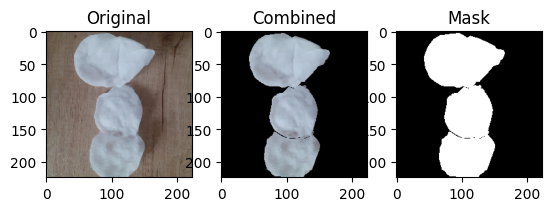

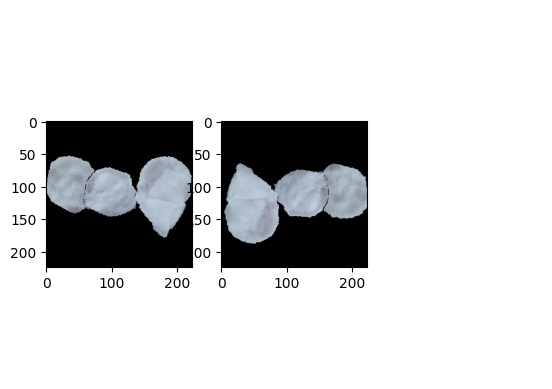

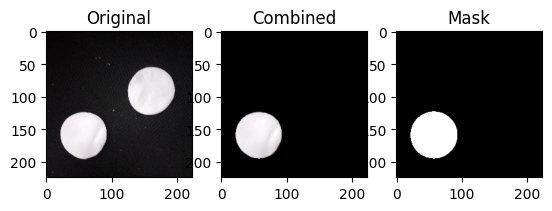

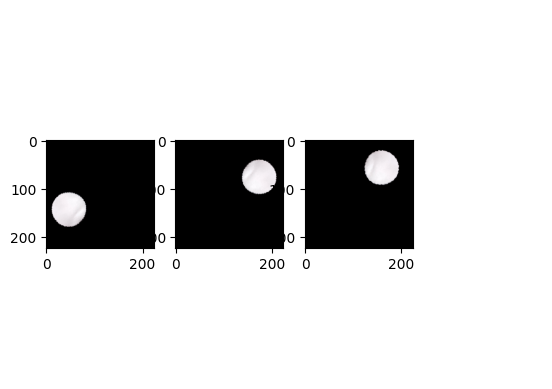

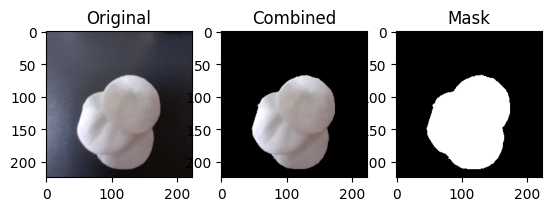

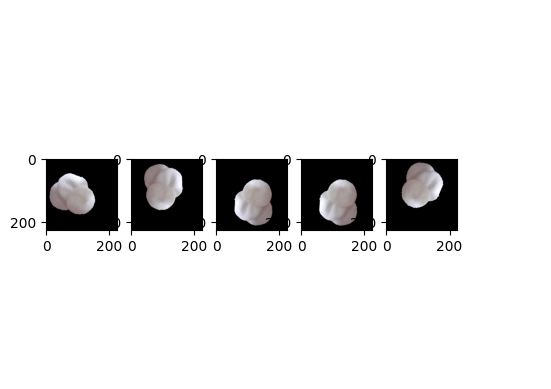

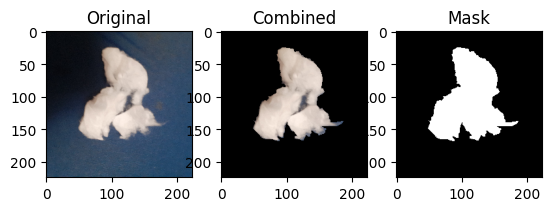

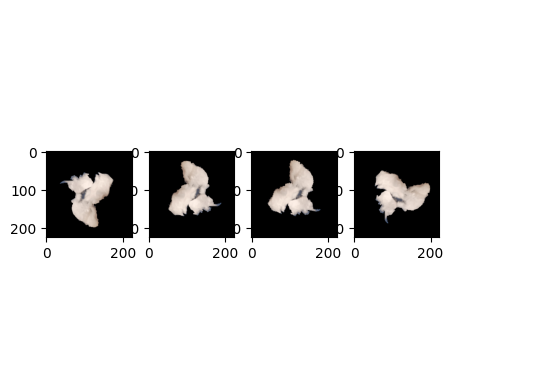

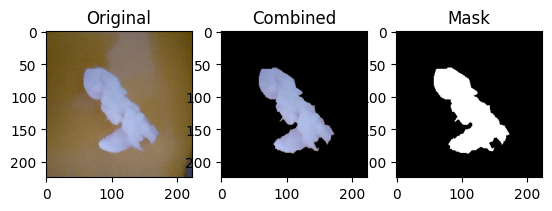

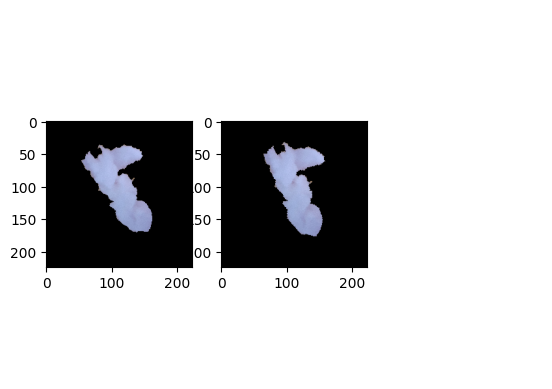

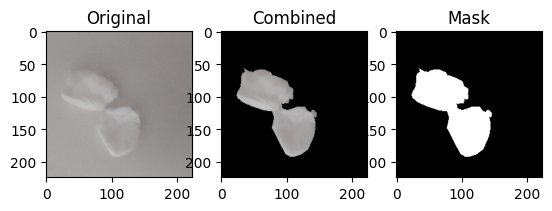

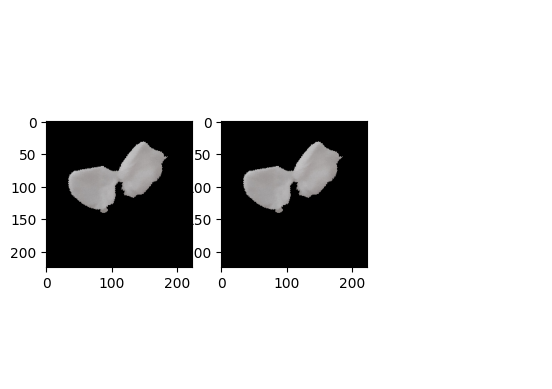

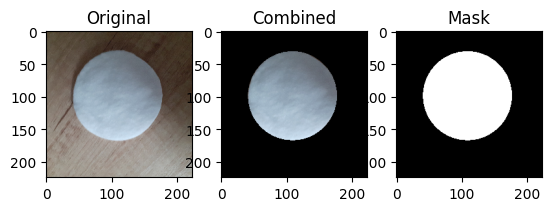

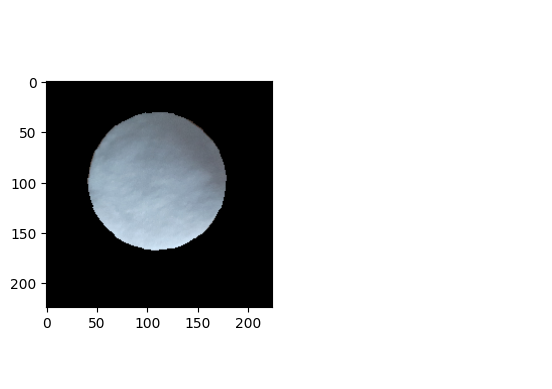

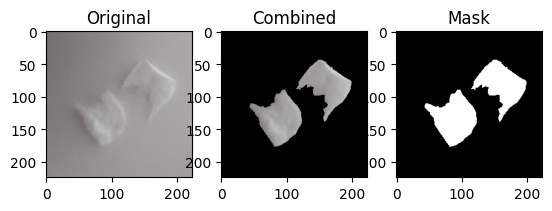

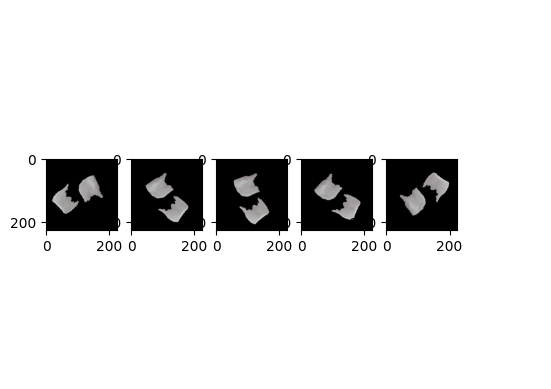

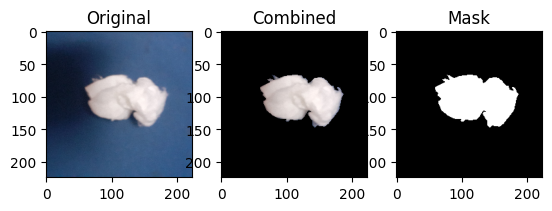

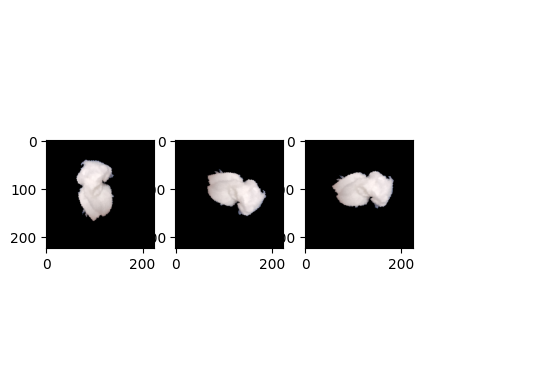

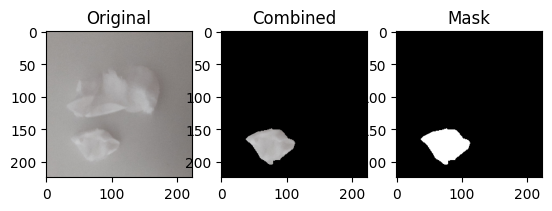

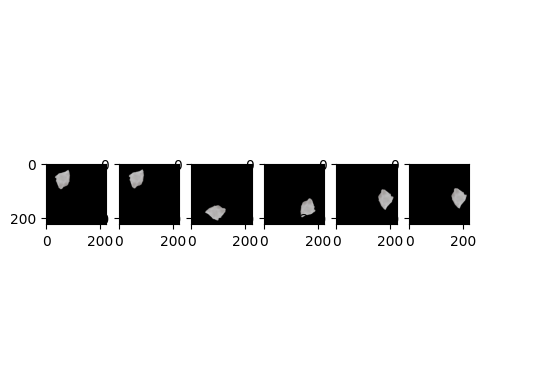

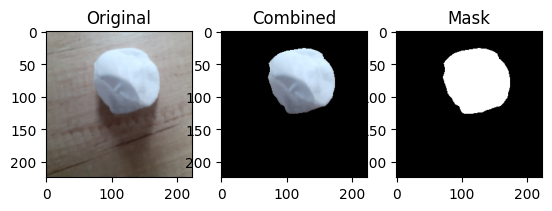

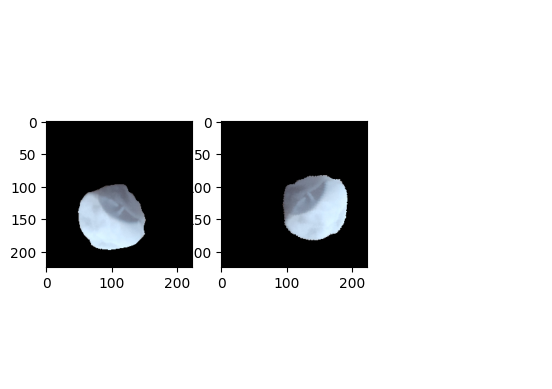

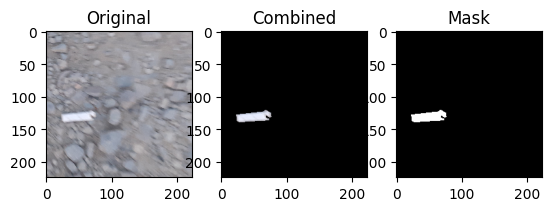

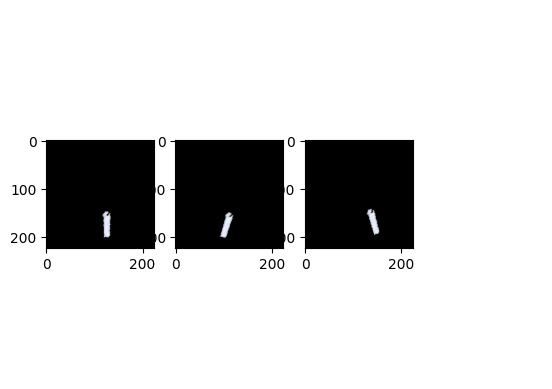

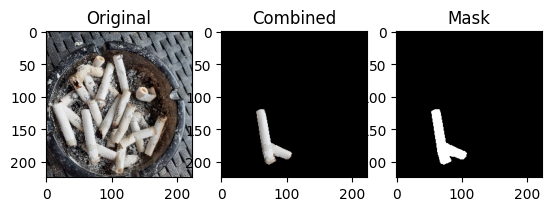

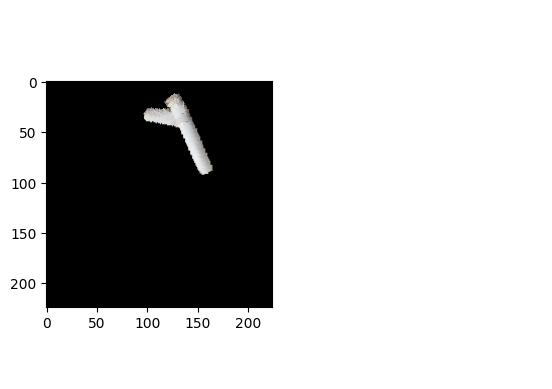

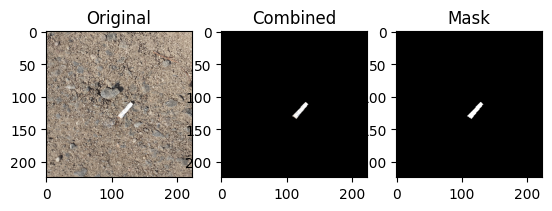

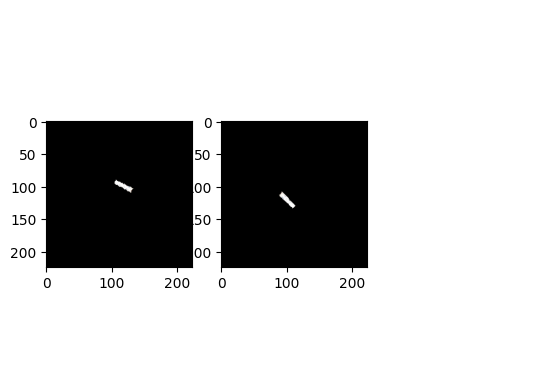

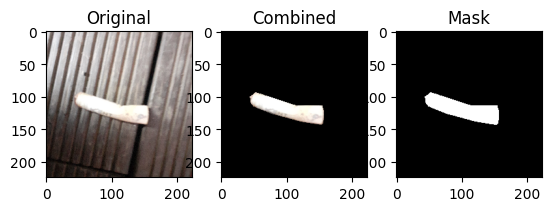

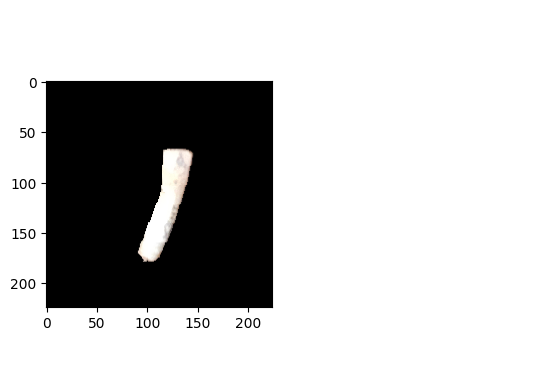

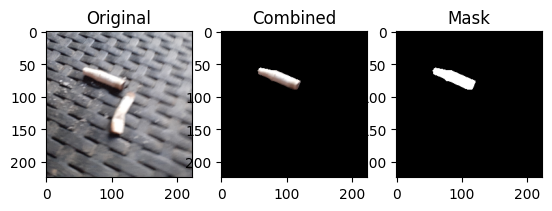

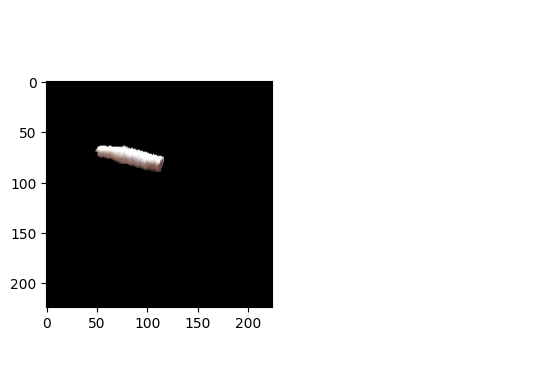

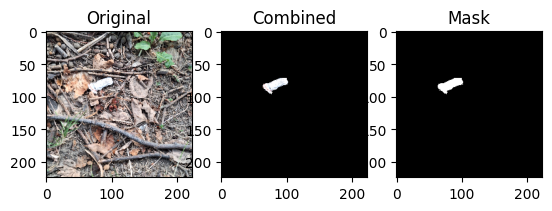

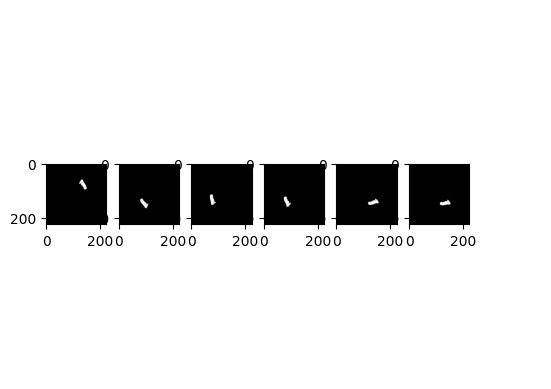

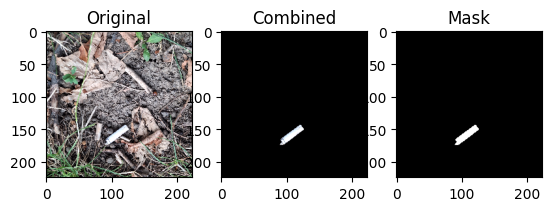

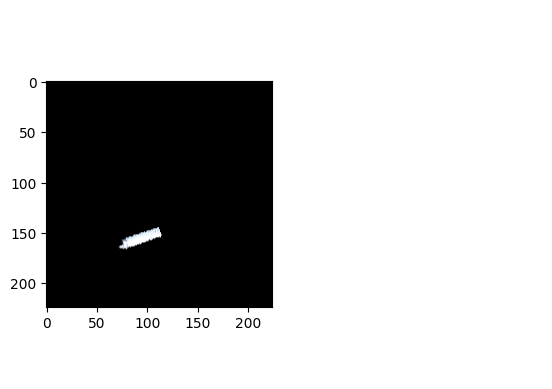

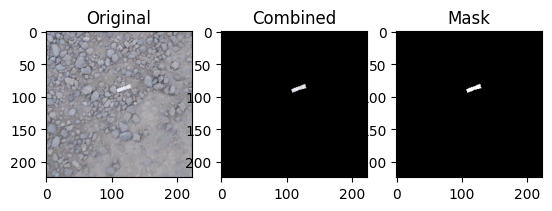

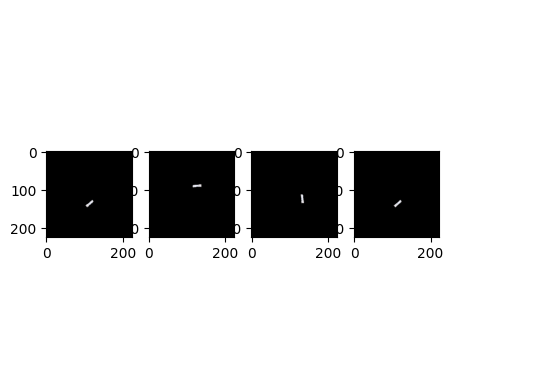

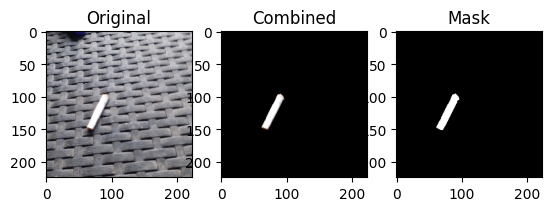

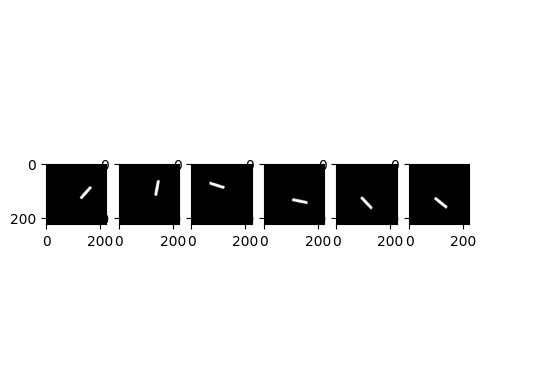

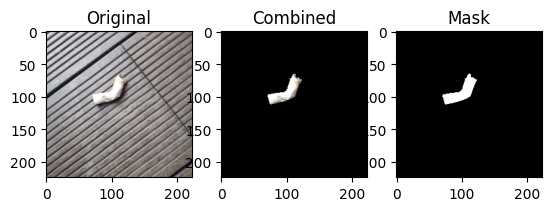

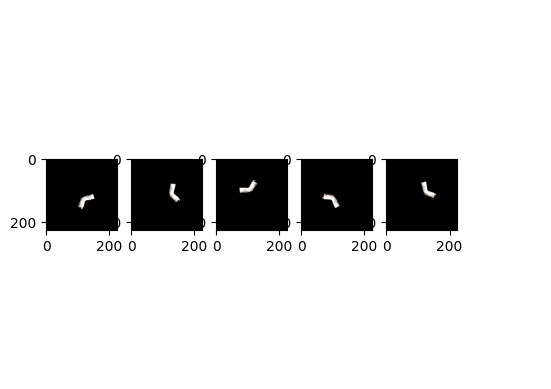

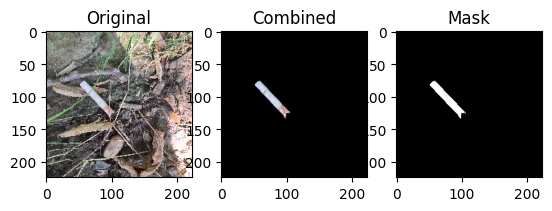

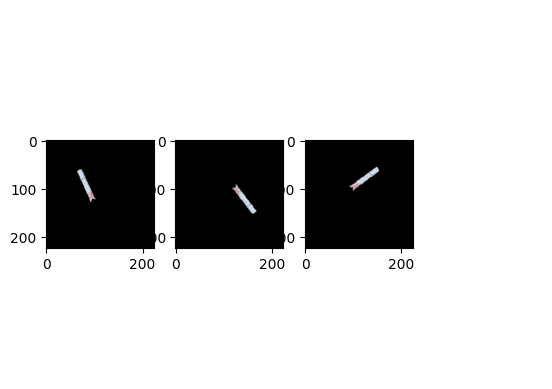

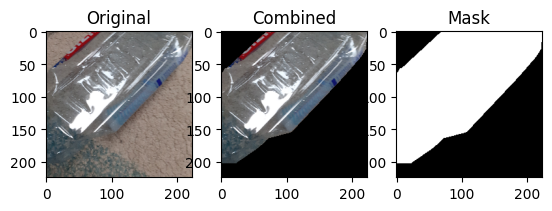

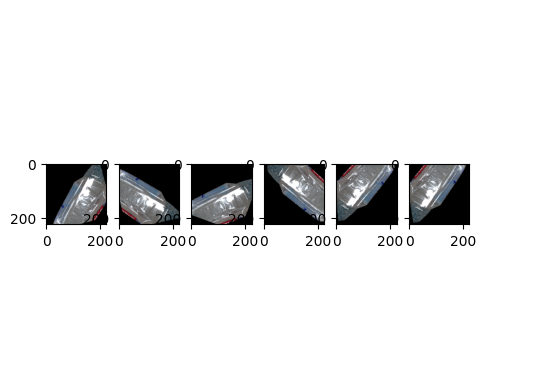

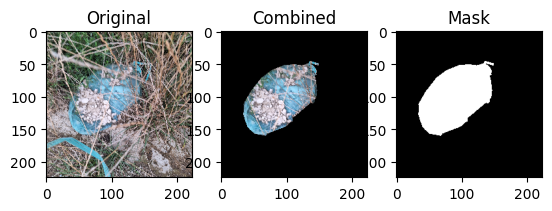

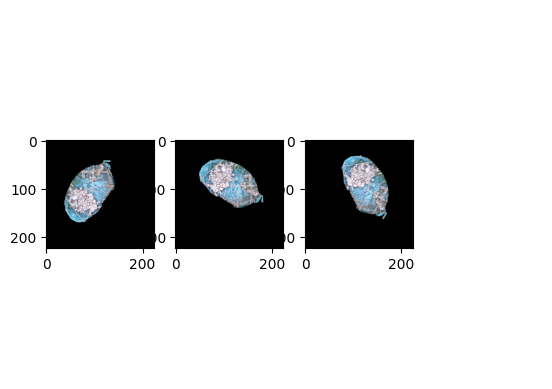

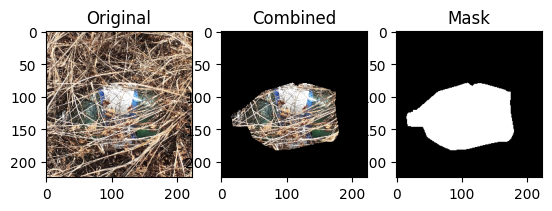

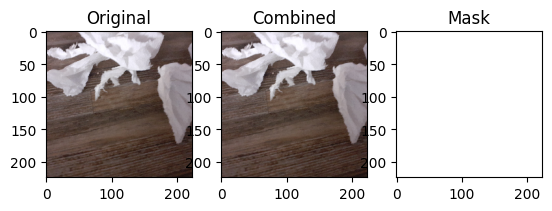

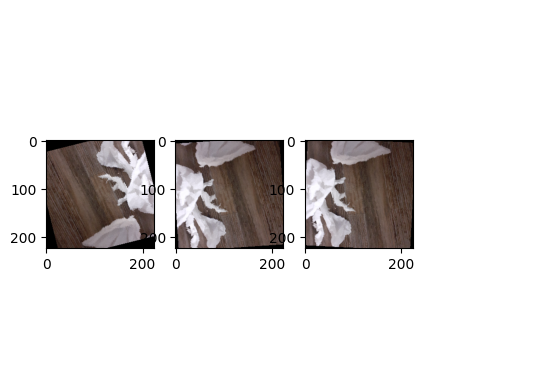

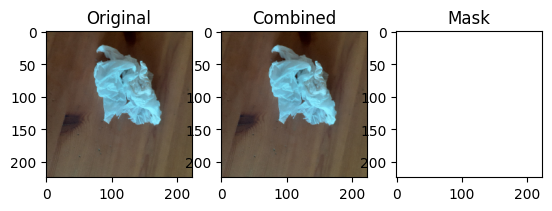

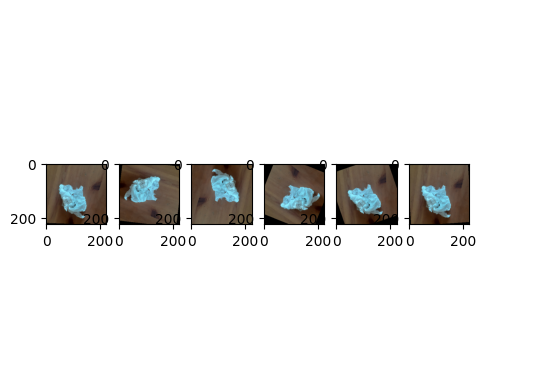

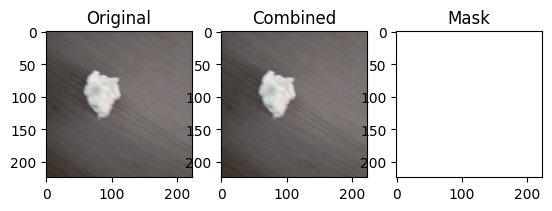

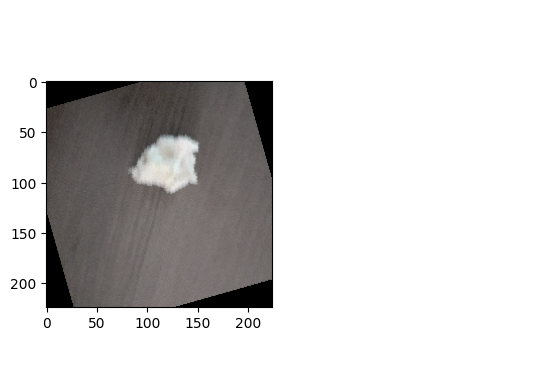

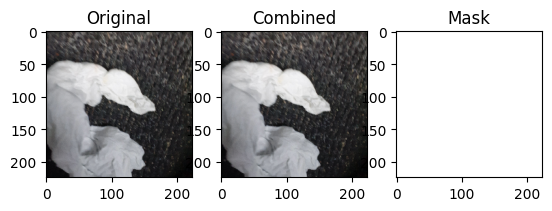

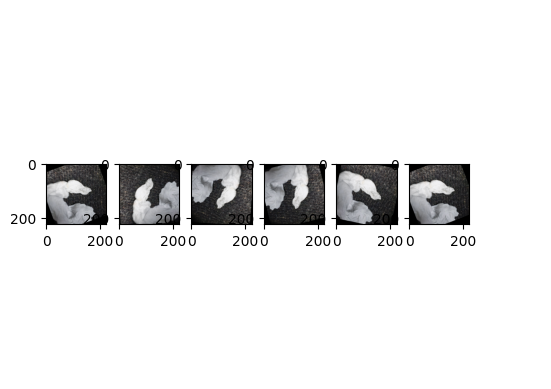

In [ ]:
annotations = []

num_images = len(via_annotations["_via_img_metadata"])
from tqdm.notebook import tqdm  # the progress bar
import random
for i, image_data in tqdm(enumerate(via_annotations["_via_img_metadata"].items()), total=num_images):
    image_info = image_data[1]
    image_id = image_data[0]
    filename = os.path.join(DATA_PATH, image_info["filename"])

    # Load the image
    try:
        img = Image.open(filename)
        # Rotate JPEGs according to the data provided by the camera
        img = ImageOps.exif_transpose(img)
    except:
        print(f"File not found: {filename}. Skipping.")
        continue
    
    WIDTH, HEIGHT = img.size  # original ones
    img = img.resize(IMAGE_RESOLUTION, resample=Image.NEAREST)

    # Create the region mask (1 means transparent)
    if image_info["regions"]:
        mask = Image.new("1", (WIDTH, HEIGHT))
    else:
        # If there aren't any regions, keep the whole image for now
        mask = Image.new("1", (WIDTH, HEIGHT), "white")
    black = Image.new("RGB", IMAGE_RESOLUTION, (0, 0, 0))

    # Extract regions (polygons, circles, rectangles, ellipses) from VIA annotations and draw them on the mask
    for region_info in image_info["regions"]:
        shape_attributes = region_info["shape_attributes"]
        region_shape = shape_attributes["name"]

        pencil = ImageDraw.Draw(mask)

        if region_shape == "polygon":
            points = [(x, y) for x, y in zip(shape_attributes["all_points_x"], shape_attributes["all_points_y"])]
            pencil.polygon(points, "white")

        elif region_shape == "circle":
            x = shape_attributes["cx"]
            y = shape_attributes["cy"]
            r = shape_attributes["r"]
            points = [(x-r, y-r), (x+r, y+r)]
            pencil.ellipse(points, "white")

        elif region_shape == "ellipse":
            ellipse = Image.new("RGBA", IMAGE_RESOLUTION, (0, 0, 0, 0))
            pencil_ellipse = ImageDraw.Draw(ellipse)
            x = shape_attributes["cx"]
            y = shape_attributes["cy"]
            rx = shape_attributes["rx"]
            ry = shape_attributes["ry"]
            angle = shape_attributes["theta"]
            
            # Since ellipses can't be easily rotated in PIL, I'll have to paste a rotated version on top of the mask
            points = [(x-rx, y-ry), (x+rx, y+ry)]
            pencil_ellipse.ellipse(points, "white")
            ellipse = ellipse.rotate(angle, expand=False, center=(x, y))
            mask.paste(ellipse, (0, 0))

        elif region_shape == "rect":
            x = shape_attributes["x"]
            y = shape_attributes["y"]
            w = shape_attributes["width"]
            h = shape_attributes["height"]

            points = [(x, y), (x+w, y+h)]
            pencil.rectangle(points, "white")
    
    # Resize the mask as well
    mask = mask.resize(IMAGE_RESOLUTION, resample=Image.NEAREST).convert("1")
    masked = Image.composite(img, black, mask)

    # Plot the three images
    import matplotlib.pyplot as plt
    f, axarr = plt.subplots(1, 3)
    plt.axis("on")
    axarr[0].imshow(img)
    axarr[0].set_title("Original")
    
    axarr[1].imshow(masked)
    axarr[1].set_title("Combined")

    axarr[2].imshow(mask, cmap="copper")
    axarr[2].set_title("Mask")

    plt.show()
    
    # Get the class label from the directory structure
    class_label = os.path.basename(os.path.dirname(filename))

    # Convert class label to one-hot encoding
    class_index = CLASS_NAMES.index(class_label)
    class_one_hot = to_categorical(class_index, num_classes=CLASS_COUNT)
    
    # Preprocess
    n_copies = random.randint(1, 6)
    f, axarr = plt.subplots(1, n_copies + 1)
    plt.axis("off")
    for j in range(0, n_copies):
        random.seed(i+j // random.randint(1, 4) + random.randint(0, 16777216))
        
        preprocessed = masked.rotate(random.randint(0, 3) * 90 + random.randint(-22, 22))
        sharpness = ImageEnhance.Sharpness(img)
        color = ImageEnhance.Color(img)
        contrast = ImageEnhance.Contrast(img)
        brightness = ImageEnhance.Brightness(img)
        
        sharpness.enhance(random.uniform(0.5, 1.5))
        color.enhance(random.uniform(0.75, 1.25))
        contrast.enhance(random.uniform(0.625, 1.375))
        contrast.enhance(random.uniform(0.5, 1.5))

        annotations.append((np.asarray(preprocessed) / 255.0, class_one_hot))
        axarr[j].imshow(preprocessed)

# Shuffle the data
shuffle(annotations)

# Convert them to Numpy arrays
images = np.array([i[0] for i in annotations])
labels = np.array([i[1] for i in annotations])


## model definition

In [11]:
base_model = VGG19(weights="imagenet", include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(CLASS_COUNT, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False


2023-10-13 15:43:02.613460: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## compilation

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0002),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

## training

In [ ]:
history = model.fit(
    images,
    labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[TqdmCallback()],
    validation_split=0.2
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
model.save("model.h5")

### fine-tuning

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("model.h5")

In [ ]:
for layer in model.layers:
    layer.trainable = True

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    images,
    labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[TqdmCallback()],
    validation_split=0.2
)

In [ ]:
model.save("model.h5")

## inferencing

In [4]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

In [5]:
model = load_model("model.h5", compile=False)

2023-10-06 13:48:06.939672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-10-06 13:48:06.939683: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
input_image = load_img("../Bottle of milk.jpg", target_size=(224, 224))
input_image = img_to_array(input_image)
input_image = input_image / 255.0
input_image = input_image.reshape((1,) + input_image.shape)

In [10]:
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions, axis=1)[0]
predicted_label = CLASS_NAMES[predicted_class]

## plot

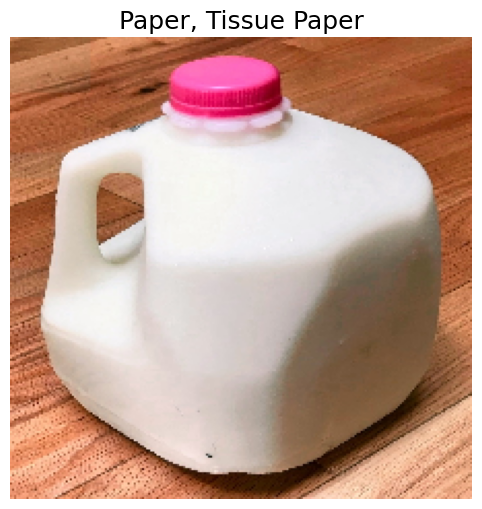

In [11]:
plt.figure(figsize=(8, 6))
plt.imshow(input_image[0])
plt.axis("off")
plt.title(predicted_label, fontsize=18)
plt.show()